# Pre-processing for Challenge 1a
This script creates task-specific features and labels for CRISPR gene disruption response prediction. The datasets used for this challenge come from the **Dependency Map (DepMap)** resource, a genome-wide CRISPR knockout viability screen of nearly all (~17,700) human genes across 341 cancer cell lines encompassing 19 tissues.

In [1]:
!pip install mygene

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re

In [3]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        print('Load network', file_name)
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
##### 
# The data are freely available under the license agreement described on their website: https://depmap.org/
# The required files can be downloaded from 'https://depmap.org/portal/download/all/' > 'DepMap Public 21Q1'
# This DepMap release contains data from CRISPR knockout screens from project Achilles, as well as genomic characterization data from the CCLE project.

in_dir = '/content/drive/MyDrive/MBP1413H/tcrp_model/data/input/'
in_task_dir = in_dir + 'Challenge1a/'
out_dir = '/content/drive/MyDrive/MBP1413H/tcrp_model/data/output/Challenge1a/' 
feature_folder = out_dir + 'feature/'


# GENE EXPRESSION DATASET:
exp_data_file = in_task_dir + 'CCLE_expression.csv'

# GENE DISRUPTION RESPONSE DATASET: CERES inferred gene knockout effect
ceres_data_file = in_task_dir + 'Achilles_gene_effect.csv'

# MUTATION DATASET:
mutation_data_file = in_task_dir + 'CCLE_mutations.csv'

# CELL LINE DESCRIPTORS DATASET: Detailed description of cell lines
cell_line_detail_file = in_task_dir + 'sample_info.csv'
original_cell_line_detail_file = in_task_dir + 'celllineinfo.csv'

gene_name_file = in_dir + 'HUGO_protein-coding_gene.tsv'

# PROTEIN-PROTEIN INTERACTION (PPI) DATASETS: PPI data from the InBioMap, PathwayCommons and CORUM databases
inbiomap_file = in_dir + 'InBioMap_Symbol.sif'
pathwaycomm_file = in_dir + 'PathwayCommons9.All.hgnc.sif'
corum_file = in_dir + 'allComplexes.txt'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [6]:
cell_line_legend = pd.read_csv(cell_line_detail_file, sep=',', index_col=1)
original_cell_line_legend = pd.read_csv(original_cell_line_detail_file, sep=',', index_col=0)
original_cell_line_info = pd.merge(cell_line_legend, original_cell_line_legend, how='inner', left_on='CCLE_Name', right_on='Name')
original_cell_line_list = list(original_cell_line_info['DepMap_ID'])
original_cell_line_list

['ACH-000007',
 'ACH-000009',
 'ACH-000012',
 'ACH-000014',
 'ACH-000015',
 'ACH-000017',
 'ACH-000018',
 'ACH-000021',
 'ACH-000022',
 'ACH-000028',
 'ACH-000030',
 'ACH-000035',
 'ACH-000036',
 'ACH-000039',
 'ACH-000040',
 'ACH-000042',
 'ACH-000045',
 'ACH-000047',
 'ACH-000053',
 'ACH-000054',
 'ACH-000055',
 'ACH-000060',
 'ACH-000067',
 'ACH-000075',
 'ACH-000078',
 'ACH-000082',
 'ACH-000085',
 'ACH-000095',
 'ACH-000096',
 'ACH-000097',
 'ACH-000098',
 'ACH-000099',
 'ACH-000108',
 'ACH-000116',
 'ACH-000118',
 'ACH-000120',
 'ACH-000123',
 'ACH-000127',
 'ACH-000132',
 'ACH-000133',
 'ACH-000137',
 'ACH-000138',
 'ACH-000142',
 'ACH-000146',
 'ACH-000148',
 'ACH-000152',
 'ACH-000159',
 'ACH-000168',
 'ACH-000169',
 'ACH-000178',
 'ACH-000189',
 'ACH-000207',
 'ACH-000208',
 'ACH-000211',
 'ACH-000215',
 'ACH-000221',
 'ACH-000222',
 'ACH-000223',
 'ACH-000226',
 'ACH-000227',
 'ACH-000231',
 'ACH-000232',
 'ACH-000234',
 'ACH-000235',
 'ACH-000237',
 'ACH-000242',
 'ACH-0002

In [7]:
exp_df = pd.read_csv(exp_data_file, sep=',', index_col=0, low_memory=False)
exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
exp_df = exp_df.drop('NO_GENE_NAME',axis=1,errors='ignore')

def stripNumber(line):
    name = re.sub(r' \([0-9]+\)', '', line)
    return name

exp_df.columns = exp_df.columns.map(stripNumber)

exp_df = exp_df.groupby(level=0).first()

exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

print(len(exp_cell_line_list), len(exp_gene_list))

exp_df

exp_gene_list = list(exp_df.columns) # HUGO Symbol
exp_cell_line_list = list(exp_df.index.unique()) # Broad IDs

1376 19177


In [8]:
maf = pd.read_csv(mutation_data_file, sep=',', index_col=1, low_memory=False).fillna(0)
mutation_df = maf.groupby(['DepMap_ID','Hugo_Symbol']).size().unstack().fillna(0).clip(upper=1)
mutation_gene_list = list(mutation_df.columns) # HUGO Symbol
mutation_cell_line_list = list(mutation_df.index.unique()) # Broad IDs

print(len(mutation_cell_line_list), len(mutation_gene_list))

1747 19541


In [9]:
ceres_df = pd.read_csv(ceres_data_file, sep=',', index_col=0, low_memory=False)
ceres_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
ceres_df = exp_df.drop('NO_GENE_NAME',axis=1,errors='ignore')

def stripNumber(line):
    name = re.sub(r' \([0-9]+\)', '', line)
    return name

ceres_df.columns = ceres_df.columns.map(stripNumber)

ceres_df = ceres_df.groupby(level=0).first()

ceres_gene_list = list(ceres_df.columns)
ceres_cell_line_list = list(ceres_df.index.unique())

print(len(ceres_cell_line_list), len(ceres_gene_list))
ceres_df

1376 19177


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
ACH-000001,5.823495,0.000000,7.369292,2.100978,4.221877,0.042644,0.910733,5.672991,4.676380,4.013462,...,1.545968,0.189034,0.275007,0.000000,0.545968,4.424922,0.000000,0.000000,0.124328,0.000000
ACH-000002,0.189034,0.000000,5.633431,1.263034,3.152183,4.189034,0.163499,4.161888,4.139961,2.799087,...,1.761285,0.000000,0.056584,0.000000,0.799087,3.748461,0.000000,0.000000,0.189034,0.000000
ACH-000003,6.035624,0.084064,7.744767,1.851999,3.895303,0.000000,0.056584,6.597978,4.734981,4.141596,...,1.895303,0.344828,0.042644,0.028569,2.914565,5.350144,0.111031,0.000000,0.070389,0.000000
ACH-000004,2.599318,0.000000,5.310340,2.467279,3.926948,0.918386,4.957915,3.912650,4.878725,4.971314,...,2.704872,0.286881,0.070389,0.454176,2.257011,6.182692,0.000000,0.000000,0.782409,0.000000
ACH-000005,3.051372,0.000000,5.754888,2.969012,5.322289,0.214125,5.762880,4.152995,5.532629,5.330558,...,2.580145,0.454176,0.137504,0.084064,1.560715,5.469886,0.000000,0.000000,0.042644,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002475,0.226509,2.553361,6.602142,2.087463,4.316146,0.000000,0.042644,4.840463,4.976364,3.746313,...,1.650765,0.150560,0.014355,0.000000,0.985500,3.456806,0.000000,0.028569,0.963474,0.000000
ACH-002508,5.556736,0.000000,6.861955,2.220330,2.843984,0.014355,4.788164,5.529509,4.036503,3.463361,...,1.485427,0.000000,0.176323,0.000000,2.056584,3.777157,0.000000,0.000000,0.286881,0.000000
ACH-002509,5.548128,0.344828,6.132166,3.249445,4.156235,0.000000,1.981853,5.844737,3.471187,4.622345,...,0.948601,0.014355,0.275007,0.000000,0.807355,5.042644,0.000000,0.000000,1.422233,0.000000
ACH-002510,4.052242,0.000000,6.295539,1.922198,2.364572,0.000000,1.495695,6.338424,3.768714,4.216455,...,0.176323,0.028569,0.042644,0.028569,2.456806,5.454505,0.000000,0.042644,1.454176,0.042644


In [10]:
valid_gene_list = list(set(exp_gene_list) | set(mutation_gene_list) | set(ceres_gene_list))

In [11]:
network_list = [inbiomap_file,pathwaycomm_file]
gene_neighbor_map = load_network(network_list, valid_gene_list) # this takes about 20 minutes to run

Load network /content/drive/MyDrive/MBP1413H/tcrp_model/data/input/InBioMap_Symbol.sif
Load network /content/drive/MyDrive/MBP1413H/tcrp_model/data/input/PathwayCommons9.All.hgnc.sif


In [12]:
gene_name_df = pd.read_table(gene_name_file, index_col=25, sep='\t', low_memory=False)

In [13]:
gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    #print(uniprot_gene)
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

In [14]:
corum_df = pd.read_table(corum_file, index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

print(len(uniprot_gene_set), 'genes')

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
print('Need to query', len(query_gene_set))

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
print(len(not_found_gene_list), 'symbol name not found', len(gene_name_map))

3674 genes
Need to query 43


26 symbol name not found 19072


In [15]:
for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

## Task-specific features
Task-specific features were constructed for each CRISPR gene disruption by selecting genes having PPI or mRNA co-expression relationships (|r| > 0.4) with the disrupted gene. For drugs with multiple targets, we included all PPI/co-expressed neighbors of these targets. Furthremore, we removed gene expression features for which the s.d.s fell into the lowest 10% over all genes and excluded genes with <10 somatic mutations across cell lines.

Somatic mutations and mRNA expression levels of the remaining selected genes were applied to construct the input feature vector for each cell line.

In [16]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print(gene1, 'not in itself?', P[i,i]) # this also takes about 15 minutes to run

In [17]:
#cell_line_list = list(set(exp_cell_line_list)&set(mutation_cell_line_list)&set(ceres_cell_line_list))
cell_line_list = list(set(exp_cell_line_list)&set(mutation_cell_line_list)&set(ceres_cell_line_list)&set(original_cell_line_list))
print(len(cell_line_list))

340


In [18]:
new_exp_df = exp_df.loc[ cell_line_list,: ]
new_mutation_df = mutation_df.loc[ cell_line_list,: ]
new_ceres_df = ceres_df.loc[ cell_line_list,: ]
new_ceres_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
ACH-000632,4.575312,0.000000,6.698218,2.313246,3.868884,0.000000,0.201634,5.935460,5.057017,4.667324,...,1.485427,0.176323,0.163499,0.111031,0.432959,5.045268,0.00000,0.111031,0.163499,0.000000
ACH-000490,4.002703,0.000000,6.284107,1.879706,3.371559,0.000000,0.137504,4.980939,7.350497,3.862947,...,2.341986,0.084064,0.014355,0.124328,0.226509,4.125982,0.00000,0.000000,0.111031,0.042644
ACH-000665,4.828327,0.028569,5.950935,2.419539,3.635754,0.084064,5.743892,6.595593,7.649759,4.280956,...,1.967169,0.070389,0.356144,0.238787,2.687061,5.341630,0.00000,0.250962,1.636915,0.000000
ACH-000805,3.785551,0.000000,6.433126,3.122673,4.232661,0.028569,0.263034,6.423746,4.367371,4.436961,...,1.500802,0.028569,0.014355,0.042644,3.835924,6.705978,0.00000,0.056584,0.948601,0.042644
ACH-000454,5.142005,0.000000,6.977394,1.378512,3.153805,0.042644,4.582556,5.011227,8.618826,4.078097,...,1.782409,0.014355,0.070389,0.124328,1.333424,5.448901,0.00000,0.000000,0.536053,0.042644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000390,5.604961,0.000000,6.381629,3.012569,4.118526,0.070389,3.931683,5.678917,8.546277,4.397118,...,1.925999,0.214125,0.014355,0.000000,3.476382,6.475896,0.15056,0.000000,0.310340,0.000000
ACH-000947,3.973611,0.176323,5.969703,2.608809,3.797013,0.042644,0.400538,3.218781,4.924575,5.132166,...,1.372952,0.000000,0.150560,0.084064,1.495695,5.453518,0.00000,0.014355,1.584963,0.014355
ACH-000040,3.804260,0.000000,6.408542,2.042644,4.034744,0.263034,5.398829,7.403523,3.198494,4.723559,...,2.336283,0.056584,0.000000,0.000000,3.798051,5.200065,0.00000,0.189034,0.150560,0.000000
ACH-000221,4.255501,0.000000,6.813268,2.272023,4.139142,0.000000,4.184280,6.029674,4.793376,5.172728,...,2.321928,0.176323,0.097611,0.000000,2.739848,6.474760,0.00000,0.028569,0.000000,0.000000


In [19]:
cell_line_legend = pd.read_csv(cell_line_detail_file, sep=',', index_col=0)
#print cell_line_legend

tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'lineage']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print(tissue, len(cell_line))

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)

skin 29
central_nervous_system 36
lung 47
upper_aerodigestive 8
pancreas 22
colorectal 25
blood 10
breast 26
fibroblast 1
liver 13
ovary 31
esophagus 10
gastric 9
urinary_tract 19
soft_tissue 4
kidney 17
uterus 12
bone 6
thyroid 1
peripheral_nervous_system 11
lymphocyte 3
How many tissues 21
Large tissues 9


In [ ]:
print(ceres_df.shape, mutation_df.shape, exp_df.shape)

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 10] # changed from 5 to 10

print(len(filtered_exp_gene_list), len(filtered_mut_gene_list), len(filtered_ceres_gene_list))

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]
new_ceres_df = ceres_df.loc[ :, list(filtered_ceres_gene_list) ]

(1376, 19177) (1747, 19541) (1376, 19177)
17259 17972 6586


In [ ]:
import scipy.stats as stats

ceres_arr = np.array(new_ceres_df.T)
z_score = np.abs(stats.zscore(ceres_arr, axis = 0))
zscore_cutoff = z_score > 6
zscore_bool = zscore_cutoff.any(axis=0)
filtered_ceres_gene_list = np.asarray(cell_line_list)[zscore_bool]
len(filtered_ceres_gene_list)

13

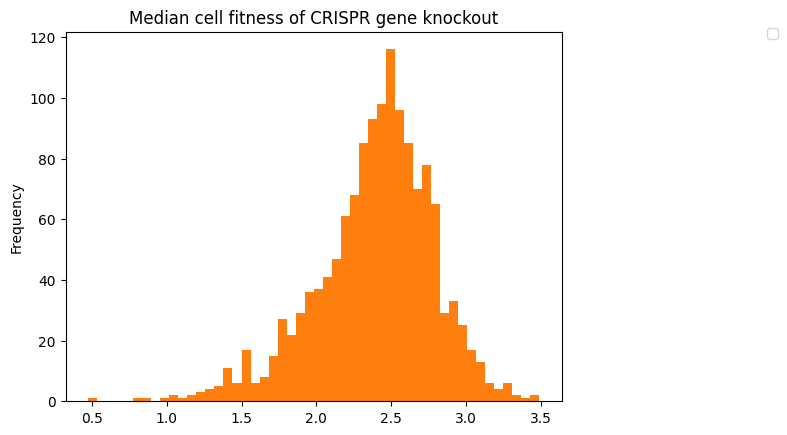

In [31]:
#np.mean(ceres_df.T,axis=0)
#np.mean(ceres_df.T,axis=1)
plt.hist(np.median(ceres_df.T,axis=0),bins=50)
plt.hist(np.mean(new_ceres_df.T,axis=0),bins=50)
#.flatten().plot(kind='kde')
#np.median(new_ceres_df.T,axis=1).plot(kind='kde')
plt.ylabel("Frequency")
plt.title("Median cell fitness of CRISPR gene knockout")
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.03), numpoints=1)

In [ ]:
new_data_file = ''

print(mutation_df.shape, exp_df.shape)

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

print(np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5))

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]


rename_selected_drug_list = []

for drug in selected_drug_list:
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
        continue # skip
        #sys.exit(1)
    
    cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
    
    feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
    feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
    
    if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
        continue
    
    feature_description = []
    
    drug_tissue_map = {}
    
    drug = drug.replace(' ','_')
    
    rename_selected_drug_list.append(drug)
    
    print(drug)
    if drug == 'Nutlin-3a_(-)':
        drug = 'Nutlin-3a'
    
    drug_folder = out_dir + 'drug_feature/' + drug + '/'
    if not os.path.exists(drug_folder):
        os.makedirs(drug_folder)
        
    print('Generate features', drug)
    
    for tissue, tissue_cell_line_list in tissue_map.items():
        
        drug_specific_cell_line = list(set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )) # changed to list
        
        drug_tissue_map[tissue] = drug_specific_cell_line
        
        feature_list = []
        
        if len(feature_exp_gene_list) != 0:
            feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
            for gene in feature_exp_gene_list:
                feature_description.append(gene+'_expression')
        
        if len(feature_mut_gene_list) != 0:
            feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
            for gene in feature_mut_gene_list:
                feature_description.append(gene+'_mutation')
            
        feature = np.concatenate(feature_list, axis=1)
        
        label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values
    
        print(feature.shape, label.shape)
     
        np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
        np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
        np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))
        
    cell_list_folder = out_dir + 'cell_line_lists/'
    if not os.path.exists(cell_list_folder):
        os.makedirs(cell_list_folder)
        
    file_handle = open(cell_list_folder + drug + '_tissue_cell_line_list.pkl',"wb")
    pickle.dump(drug_tissue_map,file_handle)
    file_handle.close()
    
file_handle = open(out_dir + 'rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()


(1001, 19100) (1013, 17418)
15676 16794
Erlotinib
Generate features Erlotinib
(134, 2590) (134,)
(27, 2590) (27,)
(9, 2590) (9,)
(20, 2590) (20,)
(2, 2590) (2,)
(15, 2590) (15,)
(54, 2590) (54,)
(6, 2590) (6,)
(2, 2590) (2,)
(22, 2590) (22,)
(8, 2590) (8,)
(4, 2590) (4,)
(4, 2590) (4,)
(12, 2590) (12,)
(0, 2590) (0,)
(2, 2590) (2,)
(2, 2590) (2,)
(18, 2590) (18,)
(0, 2590) (0,)
(0, 2590) (0,)
(2, 2590) (2,)
(2, 2590) (2,)
(2, 2590) (2,)
(8, 2590) (8,)
(1, 2590) (1,)
(2, 2590) (2,)
(1, 2590) (1,)
(2, 2590) (2,)
(0, 2590) (0,)
(1, 2590) (1,)
Rapamycin
Generate features Rapamycin
(132, 600) (132,)
(19, 600) (19,)
(7, 600) (7,)
(21, 600) (21,)
(1, 600) (1,)
(13, 600) (13,)
(60, 600) (60,)
(6, 600) (6,)
(2, 600) (2,)
(24, 600) (24,)
(8, 600) (8,)
(4, 600) (4,)
(3, 600) (3,)
(14, 600) (14,)
(1, 600) (1,)
(3, 600) (3,)
(2, 600) (2,)
(15, 600) (15,)
(0, 600) (0,)
(0, 600) (0,)
(2, 600) (2,)
(2, 600) (2,)
(3, 600) (3,)
(5, 600) (5,)
(1, 600) (1,)
(3, 600) (3,)
(0, 600) (0,)
(2, 600) (2,)
(1, 60

In [ ]:
len(drug_specific_cell_line)

1

In [ ]:
len(drug_tissue_map['breast'])

47

In [ ]:
import pickle

In [ ]:
cell_line_loc = cell_list_folder
print(cell_line_loc)

/content/drive/MyDrive/MBP1413H/tcrp_model/data/output/cell_line_lists/


In [ ]:
with open(cell_line_loc + 'BMS-754807_tissue_cell_line_list.pkl', 'rb') as f: 
    tmap= pickle.load(f)

In [ ]:
tmap.keys()

dict_keys(['haematopoietic_and_lymphoid_tissue', 'central_nervous_system', 'stomach', 'bone', 'pancreas', 'large_intestine', 'lung', 'soft_tissue', 'urinary_tract', 'autonomic_ganglia', 'oesophagus', 'upper_aerodigestive_tract', 'ovary', 'breast', 'cervix', 'endometrium', 'thyroid', 'skin', 'liver', 'adrenal_gland', 'vulva', 'prostate', 'biliary_tract', 'kidney', 'salivary_gland', 'pleura', 'NS', 'testis', 'placenta', 'small_intestine'])

In [ ]:
len(tmap['lung'])

151

In [ ]:
f = np.load(out_dir + 'drug_feature/' + 'KU-55933/lung_KU-55933_feature.npy')

In [ ]:
f.shape

(137, 780)